In [1]:
import os
from unsloth import FastVisionModel, is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig
import torch
import docdataset as dd
import wandb
from dotenv import load_dotenv
load_dotenv()

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/root/miniconda3/envs/python3.10-mt-vlm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Unsloth: Failed to patch Gemma3ForConditionalGeneration.
🦥 Unsloth Zoo will now patch everything to make training faster!


True

In [2]:
your_name='ansu0122'
model_save_name='uadoc-ada-qwen2.5vl'

In [3]:
# Hyperparameters
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

seed = 3407

model_name = "unsloth/Qwen2.5-VL-7B-Instruct"
load_in_4bit = False

lora_r = 16
lora_alpha = 16

max_steps = 1000
num_train_epochs = 1
warmup_steps = 30

learning_rate = 2e-4
weight_decay = 0.01
optim = "adamw_8bit"
lr_scheduler_type = "linear"

per_device_train_batch_size = 2
gradient_accumulation_steps = 4
max_seq_length = 2048

dataset_num_proc = 4

In [4]:
WANDB_API_KEY = os.getenv("WANDB_API_KEY")
wandb.login(key=WANDB_API_KEY)

run = wandb.init(
    project="uadoc-ada",
    name="uadoc-ada-qwen2.5vl",
    tags=["docai", "qwen2.5vl"],
    config={
        "seed": seed,

        "model_name": model_name,

        "max_steps": max_steps,
        "num_train_epochs": num_train_epochs,
        "warmup_steps": warmup_steps,

        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        "optim": optim,
        "lr_scheduler_type": lr_scheduler_type,

        "per_device_train_batch_size": per_device_train_batch_size,
        "gradient_accumulation_steps": gradient_accumulation_steps,
        "max_seq_length": max_seq_length,

        "dataset_num_proc": dataset_num_proc,
    }
)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: andriy-suh (andriy-suh-private) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
run.finish()

### Downloading the Model

In [5]:
model, tokenizer = FastVisionModel.from_pretrained(
    model_name,
    load_in_4bit = load_in_4bit, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

==((====))==  Unsloth 2025.3.19: Fast Qwen2 patching. Transformers: 4.51.0.
   \\   /|    NVIDIA GeForce RTX 4090. Num GPUs = 1. Max memory: 23.643 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


Loading checkpoint shards: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


### Adding LoRA

In [6]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = lora_r,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = lora_alpha,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = seed,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

### Data Prep

In [7]:
import docdataset as dd
import prompt_templates as pt
import string_util as su
from datasets import Dataset

In [8]:
dataset = dd.download_dataset()['train']
train_dataset = dataset.filter(lambda x: x["split"] == "train")
test_dataset = dataset.filter(lambda x: x["split"] == "test")

Generating train split: 1000 examples [00:00, 3105.70 examples/s]
Filter: 100%|██████████| 1000/1000 [00:04<00:00, 229.51 examples/s]


In [9]:
train_dataset_inflated = dd.prep_train_data(train_dataset)
train_dataset_inflated = train_dataset_inflated.shuffle(seed=seed)
len(train_dataset_inflated)

7200

In [10]:
test_dataset_inflated = dd.prep_train_data(test_dataset)
test_dataset_inflated = test_dataset_inflated.shuffle(seed=seed)
test_dataset_inflated = test_dataset_inflated.select(range(240))
len(test_dataset_inflated)

240

In [11]:
train_dataset_inflated[0]

{'id': '231fa7040af64daeb179a96a9c988019',
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=764x299>,
 'focus': 'table',
 'content': "<table><tbody><tr><td>Період</td><td>Середина 5 тис. до Р.Х.</td><td>Кінець 5 тис. до Р.Х.</td><td>Друга половина 4 тис. до Р.Х.</td><td>Розрив</td><td>500 років</td><td>Орієнтація</td></tr><tr><td>Матеріали</td><td>Кремінь</td><td>Обсидіан</td><td>Мідь</td><td>Перламутр</td><td>Грунт</td><td>Схід</td></tr><tr><td>Пам'ятки</td><td>Яма</td><td>Чаплі</td><td>Петро-Свистунове</td><td>Луганськ</td><td>Кривий Ріг</td><td>Інші</td></tr><tr><td>Ритуали</td><td>Вохра</td><td>Поховання</td><td>Кургани</td><td>Спина</td><td>Коліна догори</td><td>Захоронення</td></tr><tr><td>Вироби</td><td>Ножі</td><td>Сокири</td><td>Браслети</td><td>Намисто</td><td>Підвіски</td><td>Списи</td></tr></tbody></table>",
 'prompt': '\n        Витягни таблицю з даними, що міститься на зображенні, у форматі HTML.\n\n        Вимоги:\n        – Поверни лише HTML-код таблиці, б

In [ ]:
import random
from torchvision import transforms
from PIL import Image, ImageFile, ImageFilter

ImageFile.LOAD_TRUNCATED_IMAGES = True
to_pil = transforms.ToPILImage()

def convert_to_conversation(sample, transform=None):

    if sample.get("image") is None:
        raise ValueError(f"Image cannot be None: {sample.get('id', 'unknown')}")

    if not isinstance(sample["image"], Image.Image):
        raise TypeError(f"Image must be a PIL Image, got {type(sample['image'])}: {sample.get('id', 'unknown')}")

    image = sample["image"]
    if transform is not None:
        image = transform(image)
        image = to_pil(image)

    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": sample["prompt"]},
                {"type": "image", "image": image},
            ],
        },
        {
            "role": "assistant",
            "content": [
                {"type": "text", "text": sample["content"]}
            ],
        },
    ]
    return {"messages": conversation}


In [ ]:
# train_dataset_converted = Dataset.from_list([convert_to_conversation(sample) for sample in train_dataset_inflated])
# len(train_dataset_converted)

7200

In [ ]:
test_dataset_converted = [convert_to_conversation(sample) for sample in test_dataset_inflated]
len(test_dataset_converted)

In [87]:

class ConversationDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if isinstance(idx, list):
            return [convert_to_conversation(self.samples[i], transform=self.transform) for i in idx]
        return convert_to_conversation(self.samples[idx], transform=self.transform)


class RandomGaussianBlur:
    def __init__(self, p=0.2, radius=(0.2, 0.6)):
        self.p = p
        self.radius = radius

    def __call__(self, img):
        if random.random() < self.p:
            return img.filter(ImageFilter.GaussianBlur(radius=random.uniform(*self.radius)))
        return img

class RandomNoise:
    def __init__(self, p=0.3, std=8):
        self.p = p
        self.std = std

    def __call__(self, img):
        if random.random() < self.p:
            import numpy as np
            np_img = np.array(img).astype(np.float32)
            noise = np.random.normal(0, self.std, np_img.shape)
            np_img = np.clip(np_img + noise, 0, 255).astype(np.uint8)
            return Image.fromarray(np_img)
        return img


In [ ]:
image_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.15, contrast=0.2, saturation=0.3, hue=0.2),
    transforms.RandomRotation(degrees=1, fill=(255, 255, 255)),  
    RandomGaussianBlur(p=0.2, radius=(0.2, 0.6)),                
    RandomNoise(p=0.2, std=4),
    transforms.ToTensor(),
])

# train_dataset_list = list(train_dataset_inflated)
# train_dataset_converted_transformed = ConversationDataset(train_dataset_list, transform=image_transform)

train_dataset_converted_transformed = [convert_to_conversation(sample, transform=image_transform) for sample in train_dataset_inflated]
len(train_dataset_converted_transformed)


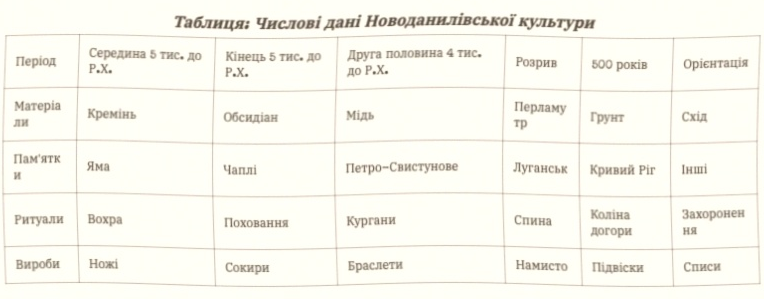

In [89]:
train_dataset_inflated[0]["image"]

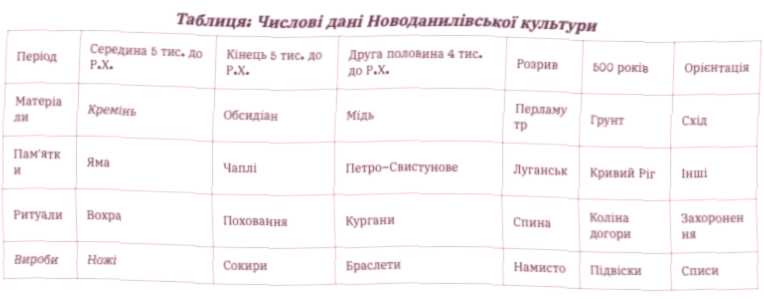

In [99]:
train_dataset_converted_transformed[0]["messages"][0]["content"][1]["image"]

### Training Setup

In [100]:
from transformers import TrainerCallback, TrainerControl, TrainerState, TrainingArguments

class EmptyCacheCallback(TrainerCallback):
    def on_step_end(self, args: TrainingArguments, state: TrainerState, control: TrainerControl, **kwargs):
        torch.cuda.empty_cache()
        return control
    
callbacks = [EmptyCacheCallback()]

In [101]:
FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = train_dataset_converted_transformed,
    eval_dataset=test_dataset_converted,
    callbacks = callbacks,
    args = SFTConfig(
        per_device_train_batch_size = per_device_train_batch_size,
        gradient_accumulation_steps = gradient_accumulation_steps,
        warmup_steps = warmup_steps,
        # max_steps = max_steps,
        num_train_epochs = num_train_epochs, # Set this instead of max_steps for full training runs
        learning_rate = learning_rate,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),

        optim = optim,
        weight_decay = weight_decay,
        lr_scheduler_type = lr_scheduler_type,
        seed = seed,
        output_dir = "train_outputs",

        report_to = "wandb",     # For Weights and Biases
        logging_steps = 10,            # Log every N steps
        eval_strategy = "steps", # Required for validation logging
        eval_steps = 100,               # Evaluate every N steps

        save_steps = 100,  # Save checkpoint every N steps
        save_total_limit = 3,  # Keep only the last 3 checkpoints
        push_to_hub = True,
        hub_model_id = f"{your_name}/{model_save_name}",
        hub_token = os.environ["HF_TOKEN"],
        hub_strategy = "checkpoint",

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = dataset_num_proc,
        max_seq_length = max_seq_length,
    ),
)

Unsloth: Model does not have a default image size - using 512


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [102]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 4090. Max memory = 23.643 GB.
15.709 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

### Saving the Latest Model

In [ ]:
your_name='ansu0122'
model_save_name='mistral-lora-zno'
# model.save_pretrained(model_save_name)  # Local saving
# tokenizer.save_pretrained(model_save_name)

model.push_to_hub(f"{your_name}/{model_save_name}", token = os.environ["HF_TOKEN"], private=True)
tokenizer.push_to_hub(f"{your_name}/{model_save_name}", token = os.environ["HF_TOKEN"], private=True)

In [ ]:
# Save full model with LoRA weights merged into base model
model = model.merge_and_unload()  # Merges LoRA weights into base
model.save_pretrained("full_model_dir")